This script explores a geosat data and does image processing to 
1) segment into respective bands
2) Compute the spatial shifts between the bands
3)  

In [17]:
import sys
sys.path.append('./utils/')
import os
from utils import io, config
from utils import image_processing as imp
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

%load_ext autoreload
%autoreload 2

dataFolder = Path(os.environ.get("GEOSATDATA_PATH"))
if not dataFolder:
    print(f"[ERROR]: Set the path to the data folder in the environment variables")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## File segmentation:
Read the tiff file and segment the array based on bands

In [2]:
dataPath = dataFolder.joinpath("image_003711.tiff") # visualize the first image
print(dataPath)
data = io.GeoFileData()
data.ReadFile(str(dataPath))

C:\Users\vivek\Documents\github\GeoSat-image-processing\data\Kaleideo IPS Dataset\image_003711.tiff


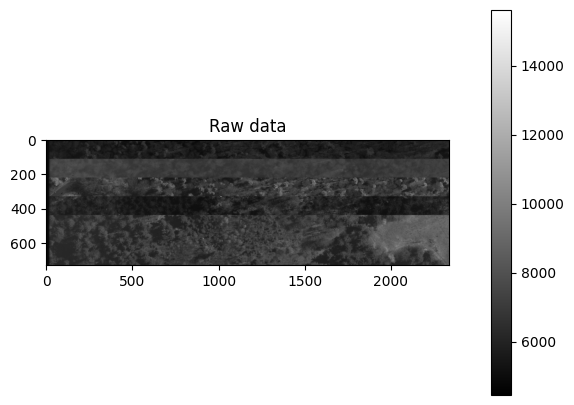

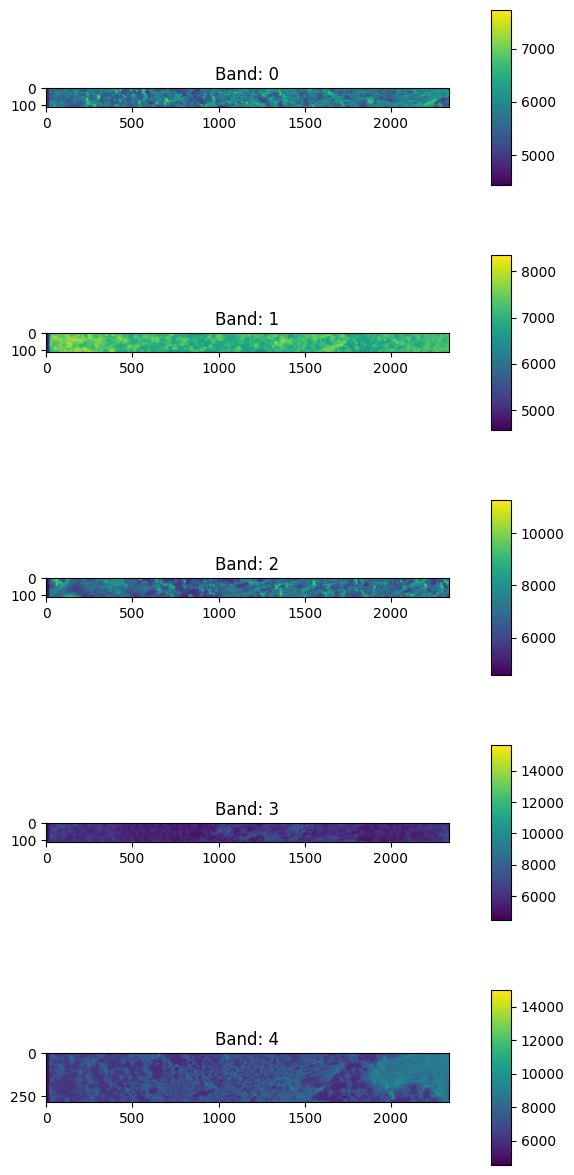

In [3]:
#Visualize the dataop0
data.DataPlainView()

## Registration of bands across multiple frames 
First lets visualize how the data looks across multiple frames

In [4]:
bandNumber = -1 # last band number {GREEN} is used to determine shift as it is the PAN band which most 
imgAlignStrategy = imp.ImageAlignmentStrategy(imp.PhaseCorrelation(), dataFolder) # set the strategy to align images
rawData = imgAlignStrategy.GetRawData(bandNumber = bandNumber)
 

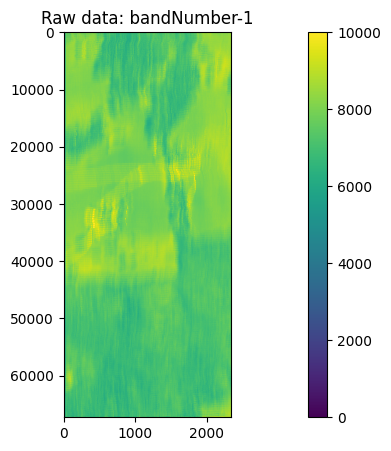

In [5]:
plt.figure(figsize = (20,5))
plt.imshow(np.flipud(rawData), aspect= 0.08)
plt.clim([0,10000])
plt.colorbar()
plt.title(f"Raw data: bandNumber{bandNumber}")
plt.show()


##### Phase correlation is used to determine the shift between the frames. Phase correlation is a lightweight algorithm and adaptable for realtime processing, that works in Fourier space and is pretty handy when the problem statement is limited to finding the linear translation between frames, given the frames are captured using the same modality. Below shows an example of registering a fixed and a moving image. The moving image is aligned to fixed with phase correlation and zero padding is added to accomodate shifts that are beyond the image boundaries.

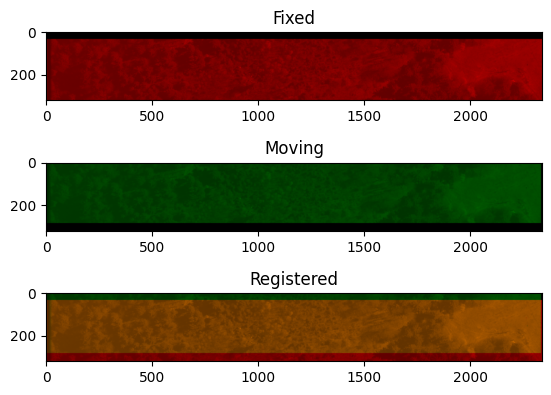

In [6]:
dataIter = io.LoadBulkData(dataFolder, '*.tiff')
fixed = next(dataIter)
moving = next(dataIter)
fixedData = fixed.data[bandNumber].astype(np.float32)
movingData = moving.data[bandNumber].astype(np.float32)

# Determine shift and align two images for example
shift, response = imgAlignStrategy.registrationManager.Register(fixedData, movingData)
paddingProps, fixedPadded, alignedPadded = imgAlignStrategy.AlignFixedAndMoving(fixedData, movingData, shift)
imgAlignStrategy.VisualizeOverlapArea(fixedPadded,alignedPadded)

Now determine the shifts for all consecutive frames and align them on top of each other.

In [18]:
alignedBands = imgAlignStrategy.AlignImages()

[INFO]: Aligning images


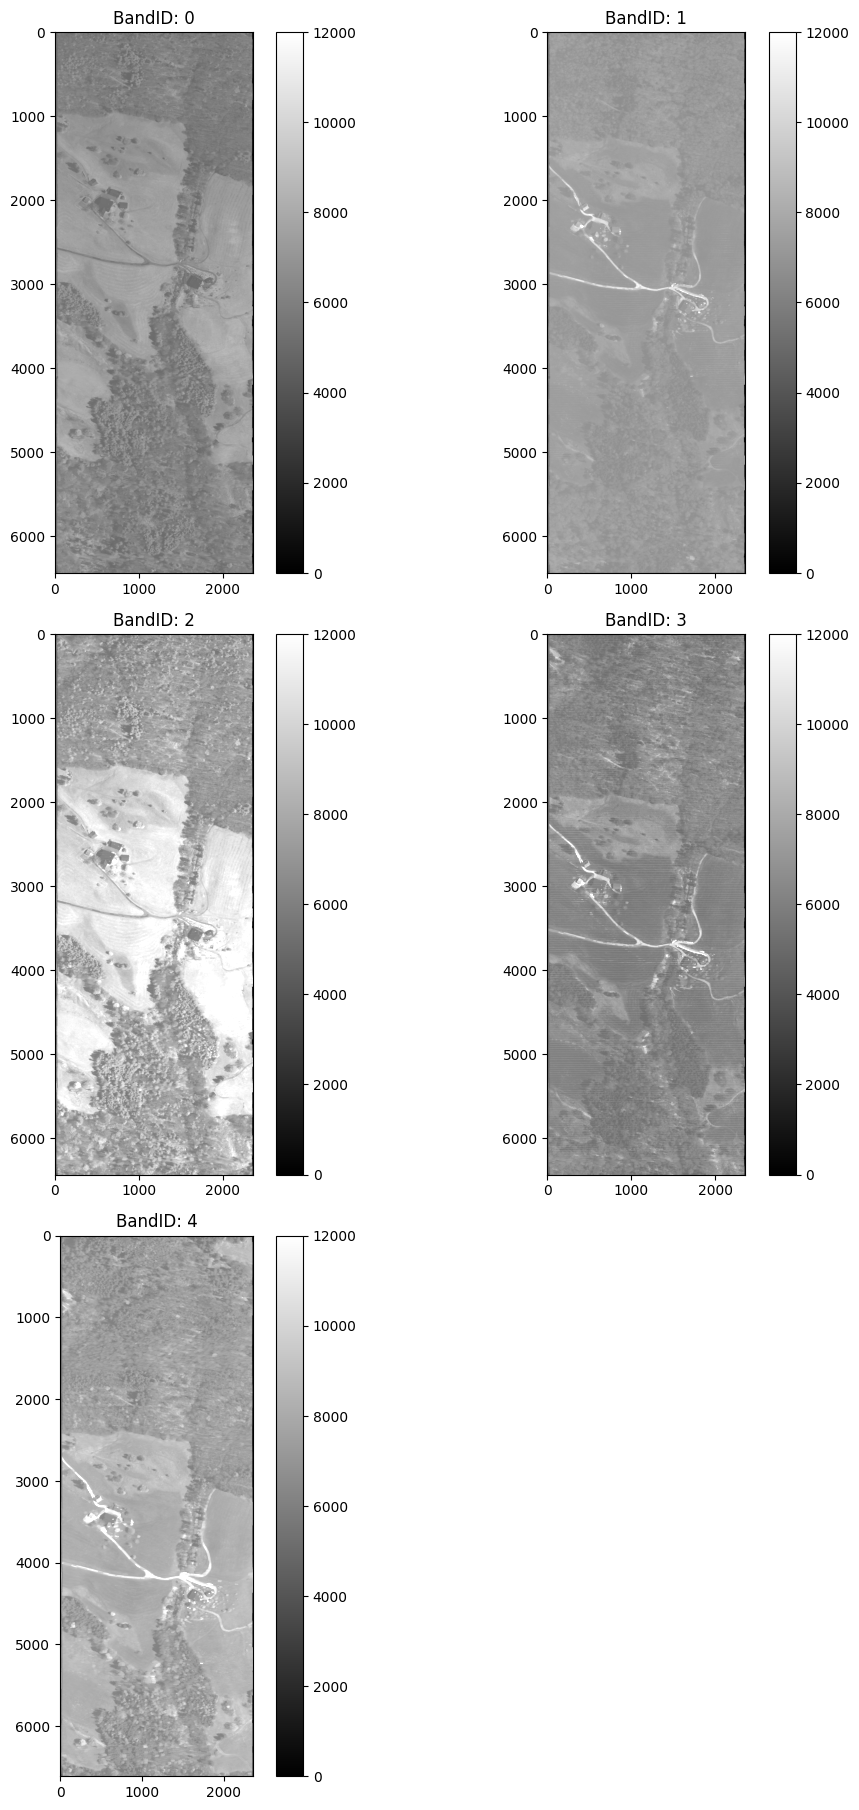

In [28]:
# Visualize aligned bands
plt.figure(figsize = (10,30))
for bandId in range(config.GEOTIFFIMAGE_BANDS):
    plt.subplot(config.GEOTIFFIMAGE_BANDS, config.GEOTIFFIMAGE_BANDS//2, bandId+1)
    plt.imshow(alignedBands[bandId], cmap = 'gray')
    plt.clim([0,1.2E4])
    plt.title(f"BandID: {bandId}")
    plt.colorbar()
    plt.tight_layout()
plt.show()